In [1]:
import pandas as pd
import geopandas as gpd
%matplotlib inline
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString, Polygon

C:\Users\gabri\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [43]:
streets =  gpd.read_file('../../data/StreetNetwork/G2_edges.shp')
buildings = gpd.read_file('../../data/Buildings/buildings.geojson')
maracana = gpd.read_file('../../data/Maracana/maracana.geojson')
                      
location_point = (-22.911667, -43.230278)
dist = 2300
parking_dist = 1000

## Getting the Buffer of the stadium

C:\Users\gabri\AppData\Local\Temp\ipykernel_4616\1664168563.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = maracana.buffer(distance=0.01)


<AxesSubplot:>

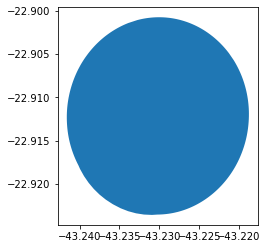

In [3]:
buffer = maracana.buffer(distance=0.01)
buffer.plot()

# Selecting roads and buildings that overleap

In [4]:
type(buffer)

geopandas.geoseries.GeoSeries

### Making buffer a geodataframe

In [5]:
buffer_gdf = gpd.GeoDataFrame(buffer)

In [6]:
buffer_gdf

,0
0,"POLYGON ((-43.24016 -22.91785, -43.24019 -22.9..."


although it's a geodataframe, buffer doesn't have a geometry, so let's add it:

In [7]:
geometria = maracana['geometry'].buffer(0.01) 
#added the geometry of the edification of maracana that I got in DataRio + 0.01 of buffer

C:\Users\gabri\AppData\Local\Temp\ipykernel_4616\1716041664.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometria = maracana['geometry'].buffer(0.01)


In [9]:
buffer_gdf.set_geometry(geometria, inplace=True)
#setting buffer's geometry

In [10]:
buffer_gdf

,0,geometry
0,"POLYGON ((-43.24016 -22.91785, -43.24019 -22.9...","POLYGON ((-43.24016 -22.91785, -43.24019 -22.9..."


### Performing the spatial join

### Streets

In [11]:
# Perform the spatial join
streets_inside = gpd.sjoin(streets, buffer_gdf, op='within')

C:\Users\gabri\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

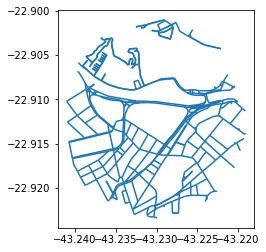

In [12]:
streets_inside.plot()

### Buildings

In [13]:
buildings_inside = gpd.sjoin(buildings, buffer_gdf, op='within')

C:\Users\gabri\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

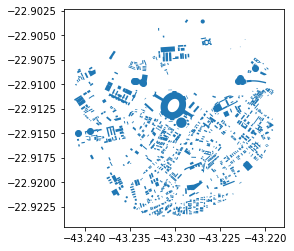

In [14]:
buildings_inside.plot()

## Plotting together

<AxesSubplot:>

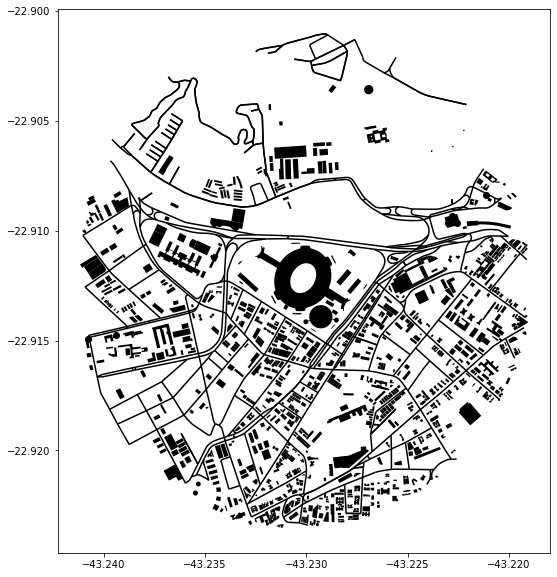

In [15]:
ax = buildings_inside.plot(color = "black", figsize=(18,10))
streets_inside.plot(ax=ax,color = "black", figsize=(18,10))

# Union 

In [16]:
from shapely.ops import cascaded_union

In [17]:
# Concatenate the two GeoDataFrames (streets and buildings)
gdf_merged = pd.concat([streets_inside, buildings_inside], ignore_index=True)

<AxesSubplot:>

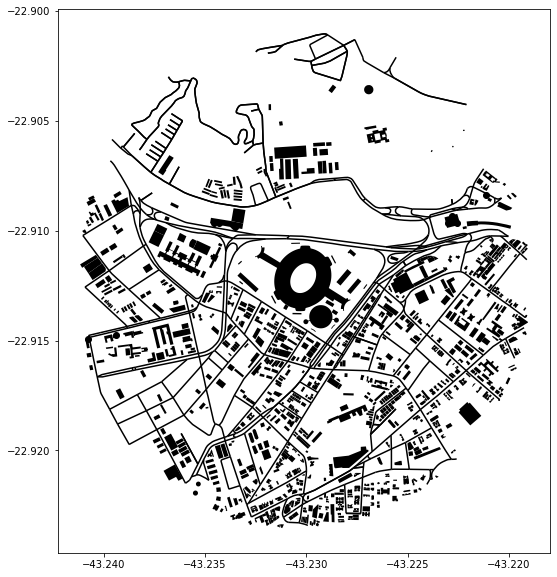

In [18]:
gdf_merged.plot(color = "black", figsize=(12,10))

## Using cascaded_union()

In [19]:
merged_gdf2 = gpd.GeoDataFrame(geometry=[cascaded_union(streets_inside.geometry.tolist()+buildings_inside.geometry.tolist())])

C:\Users\gabri\AppData\Local\Temp\ipykernel_4616\3094319154.py:1: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  merged_gdf2 = gpd.GeoDataFrame(geometry=[cascaded_union(streets_inside.geometry.tolist()+buildings_inside.geometry.tolist())])


<AxesSubplot:>

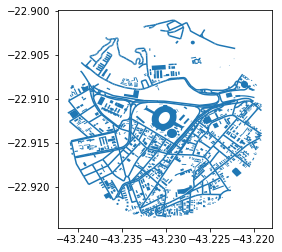

In [20]:
merged_gdf2.plot()

## Buffer of the union (ameba-like)

In [21]:
buffer_union = merged_gdf2.buffer(distance=0.01)
#since I'm using lat and long projection, distance is not in meters or km

<AxesSubplot:>

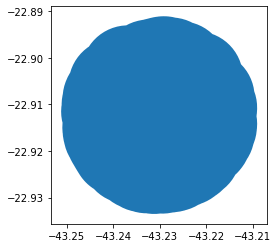

In [30]:
buffer_union.plot()

<AxesSubplot:>

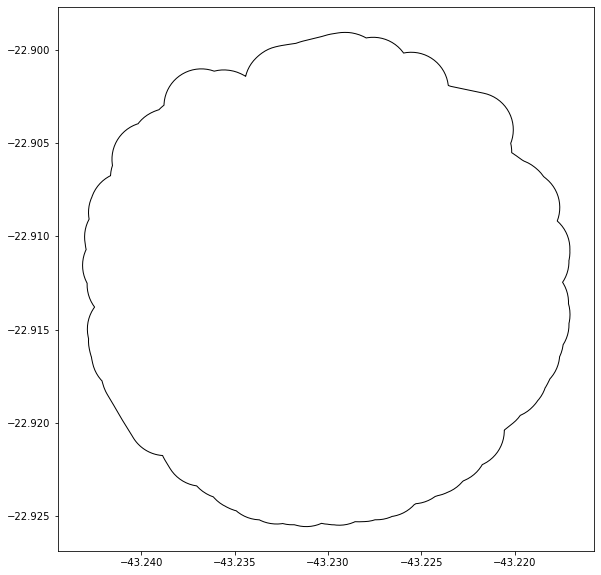

In [38]:
buffer_union2 = merged_gdf2.buffer(distance=0.002)
buffer_union2.plot(color='white', edgecolor='black', figsize=(12,10))

<AxesSubplot:>

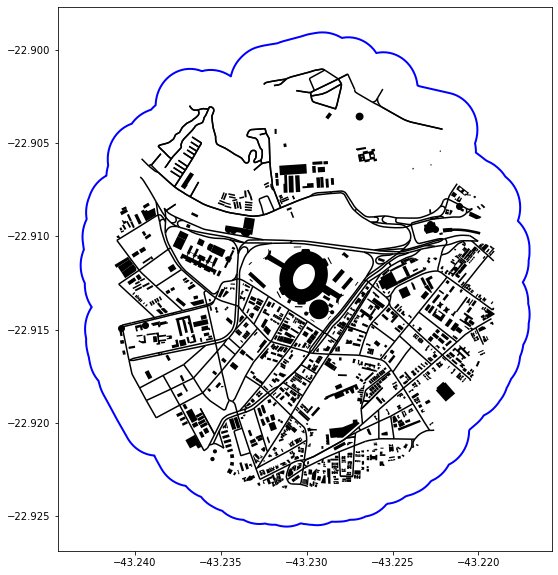

In [39]:
ax = buffer_union2.plot(color='white', edgecolor='blue', linewidth = 2, figsize=(12,10))
gdf_merged.plot(ax = ax, color="black", figsize=(12,10))

# Saving

In [40]:
import os
dir = '../../data/Ameba_Area'

if not os.path.exists(dir): 
    os.makedirs(dir)
#se essa pasta não existir, crio ela

In [41]:
buffer_union2.to_file(dir + '/Ameba_Area.geojson')